### Language modelling and byte-pair encoding
### *by Naftali N Indongo*

In [1]:
import re
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### (1.) Data

The data was obtained from the Wikipedia for five languages: Afrikaans (af), Dutch (nl), English (en), Xhosa (xh) and Zulu (zu). The Data is composed of 11 datasets; training and validation datasets for each language and a test dataset.

In [2]:
# Function for reading the data
def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read()
    return data

In [3]:
#Reading the languages datasets in python 
af_train_data, af_val_data = read_data('data/train.af.txt'), read_data('data/val.af.txt') # Afrikaans
nl_train_data, nl_val_data = read_data('data/train.nl.txt'), read_data('data/val.nl.txt') # Dutch
en_train_data, en_val_data = read_data('data/train.en.txt'), read_data('data/val.en.txt') # English
xh_train_data, xh_val_data = read_data('data/train.xh.txt'), read_data('data/val.xh.txt') # Xhosa
zu_train_data, zu_val_data = read_data('data/train.zu.txt'), read_data('data/val.zu.txt') # Zulu

#Test dataset
test_data = read_data('data/test.lid.txt')

### **(2.) Text normalization**
For each language, the training data is in its original form while text normalization has already been applied to the to the validation data. Below we will normalize the training data to match the format of the validation data for each language.

In [4]:
def normalize_text(text):
    # Split text into paragraphs
    paragraphs = text.split('\n')
    
    normalized_paragraphs = []
    
    for paragraph in paragraphs:
        # Split paragraph into sentences
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', paragraph)
        
        normalized_sentences = []
        
        for sentence in sentences:
            # Remove diacritics
            sentence = remove_diacritics(sentence)
            
            # Remove non-alphabetic characters
            sentence = re.sub(r'[^a-zA-Z\d\s]', '', sentence)
            
            # Deal with the digits
            sentence = re.sub(r'\d', '0', sentence)
            
            # Remove punctuation (except for full stops to preserve sentence boundaries)
            sentence = re.sub(r'[^\w\s]', '', sentence)
            
            # Convert to lowercase
            sentence = sentence.lower()
            
            # Remove extra whitespaces
            sentence = re.sub(r'\s+', ' ', sentence).strip()
            
            normalized_sentences.append(sentence)
        
        normalized_paragraph = '\n'.join(normalized_sentences)
        normalized_paragraphs.append(normalized_paragraph)
    
    normalized_text = '\n'.join(normalized_paragraphs)
    return normalized_text

def remove_diacritics(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    text_without_diacritics = ''.join(c for c in normalized_text if not unicodedata.combining(c))
    return text_without_diacritics

normalized_af_train_data = normalize_text(af_train_data)
normalized_nl_train_data = normalize_text(nl_train_data)
normalized_en_train_data = normalize_text(en_train_data)
normalized_xh_train_data = normalize_text(xh_train_data)
normalized_zu_train_data = normalize_text(zu_train_data)

In [5]:
Afrikaans = normalized_af_train_data.split('\n')[:-1]
Dutch = normalized_nl_train_data.split('\n')[:-1]
English = normalized_en_train_data.split('\n')[:-1]
Xhosa = normalized_xh_train_data.split('\n')[:-1]
Zulu = normalized_zu_train_data.split('\n')[:-1]

#Cleaned dataset
Language_dataset = [Afrikaans, Dutch, English, Xhosa, Zulu]

### (3.) Language modelling

#### (a) Training character-level trigram models

In our language modeling approach, we estimated the probabilities of trigrams using the Maximum Likelihood Estimation (MLE) method. Specifically, the probability of a trigram $w_t$ given its preceding bigram $w_{t-1}$ and $w_{t-2}$was estimated using the following formula:
\begin{equation}
	P_{MLE}(w_t|w_{t-1},w_{t-2})=\frac{C(w_{t-2}, w_{t-1}, w_t)}{C(w_{t-2},w_{t-1})}
\end{equation}

where $C(w_{t-2}, w_{t-1}, w_t)$ represents the count of the trigram $w_{t-2}, w_{t-1}, w_t$ in the training data, and $C(w_{t-2},w_{t-1})$ denotes the count of the bigram $w_{t-1}$ and $w_{t-2}$. 

In [6]:
#Function to generate the character-level triagrams
def generate_character_trigrams(language_sentences):
    trigrams = []
    
    for sentence in language_sentences:
        # Remove leading and trailing whitespace
        sentence = sentence.strip()
        
        # Iterate over characters in the sentence
        for char in range(len(sentence) - 2):
            trigram = sentence[char:char+3]
            trigrams.append(trigram)
    
    return trigrams
#Generate character trigrams for each language
af_trigrams = generate_character_trigrams(Afrikaans)
nl_trigrams = generate_character_trigrams(Dutch)
en_trigrams = generate_character_trigrams(English)
xh_trigrams = generate_character_trigrams(Xhosa)
zu_trigrams = generate_character_trigrams(Zulu)

In [7]:
#Function to get the triagrams counts
def get_trigram_counts(trigrams):
    trigram_counts = {}
    history_counts = {}
    hist_hist_count = {}
    
    for trigram in trigrams:
        history = trigram[:2]  # Get the history (previous two characters)
        unigram = trigram[:1] 
        
        # Increment trigram count
        if trigram in trigram_counts:
            trigram_counts[trigram] += 1
        else:
            trigram_counts[trigram] = 1
        
        # Increment history count
        if history in history_counts:
            history_counts[history] += 1
        else:
            history_counts[history] = 1
            
        # Increment history count
        if unigram in hist_hist_count:
            hist_hist_count[unigram] += 1
        else:
            hist_hist_count[unigram] = 1
    
    return trigram_counts, history_counts, hist_hist_count


In [8]:
en_trigrams_counts, en_hist_counts, en_bigram = get_trigram_counts(en_trigrams)
print(len(en_trigrams_counts))
print(len(en_hist_counts))
print(len(en_bigram))

6495
654
28


In [9]:
# Function to train the models
def Train_language_model(language_setences):
    #(1.) Generate trigrams for the given language
    trigrams = generate_character_trigrams(language_setences)
    
    #(2.) Get the counts form the unique trigrams and their history
    trigrams_counts, history_counts, history2_counts = get_trigram_counts(trigrams)
    
    #(3.) Calculate the trigram probabilities
    trigram_probs = {}
    for trigram, count in trigrams_counts.items():
        history = trigram[:2]
        prob = count/history_counts[history]
        
        #add the probability to the probabilities dictionary
        trigram_probs[trigram] = prob
        
    return trigram_probs

In [10]:
#Training the model on the 5 languages 
Afrikaans_model = Train_language_model(Afrikaans)
Dutch_model = Train_language_model(Dutch)
English_model = Train_language_model(English)
Xhosa_model = Train_language_model(Xhosa)
Zulu_model = Train_language_model(Zulu)

#Displaying all trigrams and their probabilities in the English language model with the two character history th
def get_trigrams_given_history(language_model, history):
    trigrams_with_history = {}
    for trigram, probability in language_model.items():
        if trigram[:2] == history:
            trigrams_with_history[trigram] = probability
    return trigrams_with_history

print('The 21 trigrams with the two letter character history \"th\" are:\n')
english_trigrams = get_trigrams_given_history(English_model, "th")
for trigram, probability in english_trigrams.items():
    print(f"{trigram}: {probability :.6f}")

The 21 trigrams with the two letter character history "th" are:

tha: 0.083356
tho: 0.038269
the: 0.682775
th : 0.098475
thi: 0.044816
thr: 0.033950
thu: 0.002362
thc: 0.001957
ths: 0.004117
thm: 0.000540
thw: 0.000675
thy: 0.001957
thn: 0.004590
thd: 0.000607
thl: 0.000945
tht: 0.000202
thp: 0.000135
thb: 0.000067
th0: 0.000067
thf: 0.000067
thh: 0.000067


In [11]:
# Dictionary of language models
language_models = {
    'Afrikaans': Afrikaans_model,
    'Dutch': Dutch_model,
    'English': English_model,
    'Xhosa': Xhosa_model,
    'Zulu': Zulu_model}

#### Text generation

To explore the capabilities of our models and observe how well they capture the language patterns of each specific language. we generated a 50-character sentence for  each language starting with the two-character seed 'th' as shown below:

In [12]:
#Function to generate outputs from language models
def generate_output(language_model, seed = 'th', length=100):
    output = seed
    history = seed[-2:]
    
    for _ in range(length):
        possible_trigrams = [trigram for trigram in language_model if trigram.startswith(history)]
        
        if not possible_trigrams:
            break
        
        probabilities = [language_model[trigram] for trigram in possible_trigrams]
        selected_trigram = np.random.choice(possible_trigrams, p=probabilities)
        
        output += selected_trigram[-1]
        history = selected_trigram[-2:]
    
    return output

for lang, models in language_models.items():
    print('{}: {}'.format(lang,generate_output(models, seed='th', length=50)))

Afrikaans: thetres van istronbunsie seterder in nuween bet die 
Dutch: thet nortte aar 00 hogeven naten isiterlij zinelen h
English: thing ying the abbot haver hand ral sualcon ins pate
Xhosa: thulunda okuye nga ke ba uzona ke ka belilinyale nam
Zulu: thumalikenti aberomla ia ezix sl iwe mbongayo kwa nj


#### Evaluating language models: Perplexity

We used the metric called \textit{perplexity} to evaluate the performance of our trigram language model on the validation set for each of the five languages. Perplexity measures how well the model predicts the sequence of characters in the validation set. A lower perplexity indicates that the model assigns higher probabilities to the observed data, indicating better performance. The formula for perplexity is given by:
$$PP = 2^{-\frac{1}{T}\log_2P_{\theta}(w_t|w_{t-1}, w_{t-2})}$$
where $P_\theta(w_t | w_{t-2}, w_{t-1})$ is the probability of the current trigram, and $N$ is the total number of trigrams in the validation set

In [13]:
Afrikaan_val = af_val_data.split('\n')[:-1]
Dutch_val = nl_val_data.split('\n')[:-1]
English_val = en_val_data.split('\n')[:-1]
Xhosa_val = xh_val_data.split('\n')[:-1]
Zulu_val = zu_val_data.split('\n')[:-1]

In [14]:
# generate trigrams for all the validation sets
af_val_trigrams = generate_character_trigrams(Afrikaan_val)
nl_val_trigrams = generate_character_trigrams(Dutch_val)
en_val_trigrams = generate_character_trigrams(English_val)
xh_val_trigrams = generate_character_trigrams(Xhosa_val)
zu_val_trigrams = generate_character_trigrams(Zulu_val)

# Dictionary of training sets.
training_sets = {
    'Afrikaans': af_trigrams,
    'Dutch': nl_trigrams,
    'English': en_trigrams,
    'Xhosa': xh_trigrams,
    'Zulu': zu_trigrams}

# Dictionary of validation sets
validation_sets = {
    'Afrikaans': af_val_trigrams,
    'Dutch': nl_val_trigrams,
    'English': en_val_trigrams,
    'Xhosa': xh_val_trigrams,
    'Zulu': zu_val_trigrams}

In [15]:
#function for checking the trigrams which in the validation set but not in the training set.
def get_trigrams_in_val_not_training(train_trigram, val_trigrams):
    not_in_training = []
    for trigram in val_trigrams:
        if trigram not in train_trigram:
            not_in_training.append(trigram)
    return not_in_training

# e.g.
For_af = get_trigrams_in_val_not_training(af_trigrams, af_val_trigrams)
For_nl = get_trigrams_in_val_not_training(nl_trigrams, nl_val_trigrams)
For_en = get_trigrams_in_val_not_training(en_trigrams, en_val_trigrams)
For_xh = get_trigrams_in_val_not_training(xh_trigrams, xh_val_trigrams)
For_zu = get_trigrams_in_val_not_training(zu_trigrams, zu_val_trigrams)

print(f'For Afrikaans, there {len(For_af)} trigrams in the validation set which are not in the training set.')
print(f'For Dutch, there {len(For_nl)} trigrams in the validation set which are not in the training set.')
print(f'For English, there {len(For_en)} trigrams in the validation set which are not in the training set.')
print(f'For Xhosa, there {len(For_xh)} trigrams in the validation set which are not in the training set.')
print(f'For Zulu, there {len(For_zu)} trigrams in the validation set which are not in the training set.')

For Afrikaans, there 664 trigrams in the validation set which are not in the training set.
For Dutch, there 728 trigrams in the validation set which are not in the training set.
For English, there 640 trigrams in the validation set which are not in the training set.
For Xhosa, there 719 trigrams in the validation set which are not in the training set.
For Zulu, there 2892 trigrams in the validation set which are not in the training set.


In [16]:
# Function to calculate perplexity with add-alpha smoothing
def calculate_perplexity(trigram_model, validation_set, alpha):
    log_likelihoods = []
    vocabulary_size = len(trigram_model)
    N = len(validation_set)

    # Calculate log-likelihood for each trigram in the validation set
    for trigram in validation_set:
        trigram_prob = trigram_model.get(trigram, alpha / (alpha*vocabulary_size))  # Get trigram probability from the model

        log_likelihoods.append(np.log2(trigram_prob))

    # Calculate average log-likelihood and perplexity
    average_log_likelihood = sum(log_likelihoods) / len(validation_set)
    perplexity = 2 ** (-average_log_likelihood)

    return perplexity

In [17]:
alpha = 0.1
validation_sets = validation_sets
# Create a dictionary to store perplexity values
perplexity_dict = {}

# Calculate cross-lingual perplexity for each language model and validation set
for lang, model in language_models.items():
    perplexity_dict[lang] = {}
    for val_lang, val_set in validation_sets.items():
        perplexity = calculate_perplexity(model, val_set, alpha)
        perplexity_dict[lang][val_lang] = perplexity

# Create a list of languages and validation sets
languages = list(language_models.keys())
validation_sets = list(validation_sets.keys())

# Create an empty confusion matrix with labels
Cross_lig_perplexity = np.zeros((len(languages), len(validation_sets)))
Cross_lig_perplexity = pd.DataFrame(Cross_lig_perplexity, index=languages, columns=validation_sets)

# Fill the confusion matrix with perplexity values
for lang in languages:
    for val_lang in validation_sets:
        perplexity = perplexity_dict[lang][val_lang]
        Cross_lig_perplexity.loc[lang, val_lang] = perplexity

# Display the confusion matrix
print(Cross_lig_perplexity)


           Afrikaans      Dutch    English      Xhosa       Zulu
Afrikaans   7.949203  11.444800  18.307241  43.649527  45.656553
Dutch      10.646834   7.742023  15.234679  52.431690  54.124213
English    20.820466  22.214238   7.659873  51.075642  55.579143
Xhosa      29.047159  30.451402  16.607398   8.152562   8.909480
Zulu       32.384335  33.430517  20.066052   9.564616   8.489959


### (4.) Language identification

We we will use our trained trigram models to perform language identification on the test set by calculating the perplexity of each sentence under each language model. The language with the lowest perplexity is selected as the predicted language for the sentence. 

In [18]:
# Load test data from file
test_data = []
with open('data/test.lid.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if ' ' in line:
            language, sentence = line.split(' ', 1)
            test_data.append((language, generate_character_trigrams([sentence])))

# test set is converted to the format:
# """
# [
#   ('zu', ['enc','ncw','cwa','wad','adi','din','ini','ni ','i k',' ka',...])
#   ('af', ['op ','p d',' da','daa','aar','ard','rdi','die','ie ','e s',...])
#   ('nl', ['zui', 'uid', 'ida', 'daf', 'afr', 'fri', 'rik', 'ika', kay,...])
#   ('xh', ['umz','mzi','zi ','i o',' ok','oko','kok','okw','kwa','waw',...])
#   ('en', ['the','he ','e t',' th','the','her','ere','rem','emi','min',...])
#       .
#       .
#       .
# ]
# """
# Give the Language models based on the identification keys.
Language_models = {
    "af": Afrikaans_model,
    "nl": Dutch_model,
    "en": English_model,
    "xh": Xhosa_model,
    "zu": Zulu_model
}

# Delete all the elements where trigram_list is an empty list
test_data = [(language, trigrams) for language, trigrams in test_data if trigrams != []]


In [19]:
#function for performing language identification
def language_identification(sentence_trigrams, language_models):
    min_perplexity = float('inf')
    predicted_language = None
    
    # Calculate perplexity for each language model
    for language, model in language_models.items():
        perplexity = calculate_perplexity(model, sentence_trigrams, alpha)

        # Update predicted language if perplexity is lower
        if perplexity < min_perplexity:
            min_perplexity = perplexity
            predicted_language = language
    
    return predicted_language, min_perplexity

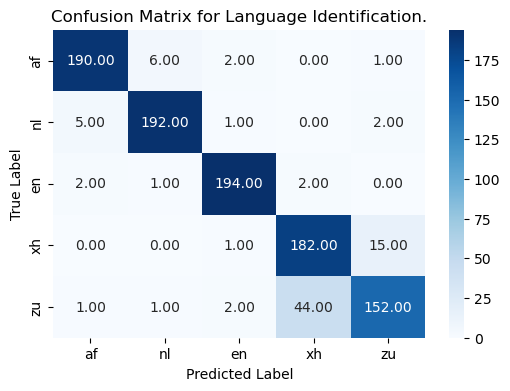

Language Identification Accuracy: 91.37%

There are 910 correct language identification and 86 wrong identification.


In [20]:
# Perform language identification on test data
correct_predictions = 0
wrong_predictions = 0
total_sentences = len(test_data)
true_preds = []
false_preds = []

# Initialize empty lists for true labels and predicted labels
true_labels = []
predicted_labels = []

for true_language, sentence_trigrams in test_data:
    predicted_language, perplexity = language_identification(sentence_trigrams, Language_models)
    
    true_labels.append(true_language)
    predicted_labels.append(predicted_language)
    
    if predicted_language == true_language:
        true_preds.append((predicted_language, true_language))
        correct_predictions += 1
    else:
        false_preds.append((true_language, predicted_language))
        wrong_predictions += 1
        
# Create a list of all possible labels
labels = list(Language_models.keys())

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Language Identification.")
plt.show()
    
# Calculate accuracy
accuracy = correct_predictions / total_sentences

print("Language Identification Accuracy: {:.2%}".format(accuracy))
print("")
print(f"There are {correct_predictions} correct language identification and {wrong_predictions}\
 wrong identification.")

In [21]:
#We will closely look at the missidentification
for true_language, predicted_language in false_preds:
    print("True Language: {}".format(true_language))
    print("Predicted Language: {}".format(predicted_language))
    print("Perplexity: {:.5f}".format(perplexity))
    print("---------------------")


True Language: zu
Predicted Language: xh
Perplexity: 7.48582
---------------------
True Language: nl
Predicted Language: af
Perplexity: 7.48582
---------------------
True Language: xh
Predicted Language: zu
Perplexity: 7.48582
---------------------
True Language: zu
Predicted Language: xh
Perplexity: 7.48582
---------------------
True Language: zu
Predicted Language: xh
Perplexity: 7.48582
---------------------
True Language: zu
Predicted Language: xh
Perplexity: 7.48582
---------------------
True Language: nl
Predicted Language: af
Perplexity: 7.48582
---------------------
True Language: zu
Predicted Language: xh
Perplexity: 7.48582
---------------------
True Language: nl
Predicted Language: zu
Perplexity: 7.48582
---------------------
True Language: af
Predicted Language: nl
Perplexity: 7.48582
---------------------
True Language: xh
Predicted Language: zu
Perplexity: 7.48582
---------------------
True Language: zu
Predicted Language: af
Perplexity: 7.48582
---------------------
True

### 5. Byte-pair encoding for language similarlity

Instead of using language model perplexity to compare similarlity between languages, we will apply a subword token learner to the data from each language and then consider the overlap between subword types. Below we will use byte-pair encoding (BPE).

We will implement the token learner code for BPE from scratch and apply the the code to each of the training sets for 100 merges as shown below:

In [22]:
def get_vocab_n_tokens(sentences):
    """
    Input: list of sentences in a given language and
    return: vocabularly (list of unique chatacters)
    """
    tokens = []
    for sentence in sentences:
        for char in sentence:
            tokens.append(char)
         # Add sentence boundary marker
        tokens.append("</s>")
        
    Vocabulary =list(set(tokens))
    
    return Vocabulary, tokens

def get_pair_frequencies(tokens):
    """
    Input: list of token
    return: Dictionay with the adjacent pairs of tokens and their counts
    """
    pairs = Counter()
    for i in range(len(tokens) - 1):
        pairs[tokens[i], tokens[i+1]] += 1
    return pairs

def merge_most_frequent_pair(tokens,vocabulary, K):
    """
    The function
    inputs: token - initial tokens
            vocabularly - initial vocabulary
            K - Number of merge iterations 
    computes the most frequent pair of adjecent tokens t_L, t_R, merge(t_new) them and add them to the vocabulary,
    and replace every instance of t_L, t_R with t_new.
    
    returns: merged tokens and updated vocabulary 
    """
    for i in range(K):
        pair_frequencies = get_pair_frequencies(tokens)
        if not pair_frequencies:
            break
        most_frequent_pair = max(pair_frequencies, key=pair_frequencies.get)
        t_new = ''.join(most_frequent_pair)
        
        vocabulary.append(t_new)
        merged_tokens = []
        i = 0
        while i < len(tokens):
            if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) == most_frequent_pair:
                merged_tokens.append(t_new)
                i += 2
            else:
                merged_tokens.append(tokens[i])
                i += 1
        tokens = merged_tokens

#         Vocabulary.append(new_token)
    return tokens, vocabulary

def apply_bpe(training_sentences, K):
    Vocab, tokens = get_vocab_n_tokens(training_sentences)
    final_vocab, final_tokens = merge_most_frequent_pair(tokens, Vocab, K)
    return final_tokens, final_vocab

K = 100

Final_Vocab, Merged_tokens = apply_bpe(Afrikaans, K)

In [23]:
languages = ['Afrikaans','Dutch','English','Xhosa','Zulu']
Training_datas = {'Afrikaans': Afrikaans , 'Dutch': Dutch, 'English': English, 'Xhosa': Xhosa, 'Zulu': Zulu} 

# Applying the code to each of the training sets for 100 merge iterations.
BPE_merged_5_languages = {}
for lang, data in Training_datas.items():
     BPE_merged_5_languages[lang] = apply_bpe(data, K)

In [24]:
# Printing the characters merged in the first ten iterations
for lang, bpe_model in BPE_merged_5_languages.items():
    Fin_Vocab = bpe_model[0]
    print(f'For {lang}, the characters merged in the first ten iterations:')
    for char in Fin_Vocab[29:39]:
        print((char[0],char[1]))
    print('')

For Afrikaans, the characters merged in the first ten iterations:
('e', ' ')
('n', ' ')
('e', 'r')
('d', 'i')
('d', 'i')
('s', ' ')
('t', ' ')
('a', 'n')
('0', '0')
('e', 'l')

For Dutch, the characters merged in the first ten iterations:
('n', ' ')
('e', ' ')
('e', 'n')
('e', 'r')
('t', ' ')
('d', 'e')
('e', 'n')
('a', 'a')
('s', ' ')
('e', 'l')

For English, the characters merged in the first ten iterations:
('e', ' ')
('s', ' ')
('t', 'h')
('d', ' ')
('i', 'n')
('a', 'n')
('e', 'r')
('o', 'n')
('t', 'h')
('t', ' ')

For Xhosa, the characters merged in the first ten iterations:
('a', ' ')
('e', ' ')
('a', 'n')
('i', ' ')
('o', ' ')
('k', 'u')
('n', 'g')
('e', 'l')
('i', 'n')
('e', 'n')

For Zulu, the characters merged in the first ten iterations:
('a', ' ')
('n', 'g')
('i', ' ')
('e', ' ')
('a', 'n')
('o', ' ')
('k', 'u')
('t', 'h')
('e', 'l')
('z', 'i')



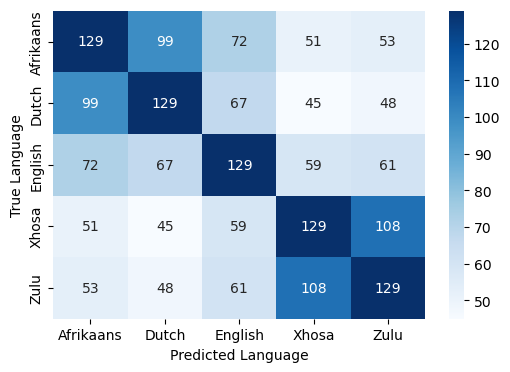

In [25]:
# Calculate vocabulary overlap
overlap_matrix = {}
for lang1, vocab1 in BPE_merged_5_languages.items():
    overlap_matrix[lang1] = {}
    for lang2, vocab2 in BPE_merged_5_languages.items():
        intersection = set(vocab1[1]).intersection(set(vocab2[1]))
        overlap_matrix[lang1][lang2] = len(intersection)
        
# Convert the overlap matrix to a DataFrame
overlap_DF = pd.DataFrame(overlap_matrix, index=languages, columns=languages)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(overlap_DF, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Language")
plt.ylabel("True Language")
# plt.title("Confusion Matrix - Subword Vocabulary Overlap")
plt.show()

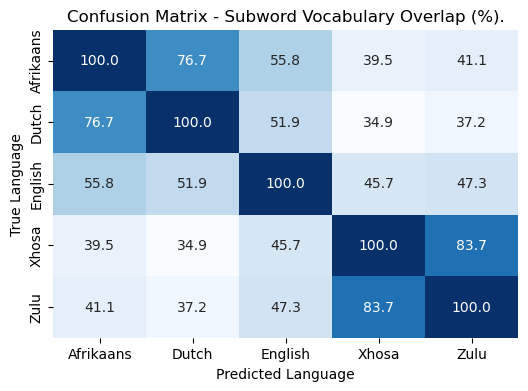

In [26]:
# Calculate vocabulary overlap
overlap_matrix = {}
for lang1, vocab1 in BPE_merged_5_languages.items():
    overlap_matrix[lang1] = {}
    for lang2, vocab2 in BPE_merged_5_languages.items():
        intersection = set(vocab1[1]).intersection(set(vocab2[1]))
        overlap_matrix[lang1][lang2] = len(intersection) / len(vocab1[0]) * 100

# Convert the overlap matrix to a DataFrame
overlap_DF = pd.DataFrame(overlap_matrix, index=languages, columns=languages)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(overlap_DF, annot=True, cmap="Blues", fmt=".1f", cbar=False)
plt.xlabel("Predicted Language")
plt.ylabel("True Language")
plt.title("Confusion Matrix - Subword Vocabulary Overlap (%).")
plt.show()